# MCOC Action Predictor from Video Frames (Optimized + Multimodal)

This notebook trains a deep learning model to predict actions in the game *Marvel Contest of Champions (MCOC)* based on sequences of screen frames **and the sequence of preceding actions**. The model uses a pre-trained MobileNetV2 as a CNN backbone to extract features from each frame, combines them with an embedding of the previous action, and then uses a GRU network to understand the temporal sequence of these combined features.

**This version has been optimized for significantly faster GPU training by implementing vectorized operations, Automatic Mixed Precision (AMP), and efficient data loading.**

In [8]:
%pip install mss keyboard opencv-python numpy torch torchvision torchaudio pillow matplotlib scikit-learn seaborn tqdm requests

### 1. Imports

First, let's import all the necessary libraries.

In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from collections import defaultdict
import re
from typing import List, Tuple, Dict
import json
import sys
import zipfile
import requests
from tqdm.notebook import tqdm # <-- OPTIMIZATION: For better progress bars
from torch.cuda.amp import GradScaler, autocast # <-- OPTIMIZATION: For Mixed Precision Training

RAW_DIR = "assets/data/raw"
RAW_ZIP_URL = "https://huggingface.co/datasets/Pablo276/mcoc_labeled_images/resolve/main/raw.zip"
RAW_ZIP_PATH = "assets/data/raw.zip"

def is_dir_empty(path):
    return not os.path.exists(path) or (os.path.isdir(path) and len(os.listdir(path)) == 0)

if is_dir_empty(RAW_DIR):
    os.makedirs(RAW_DIR, exist_ok=True)
    print(f"Downloading dataset from {RAW_ZIP_URL} ...")
    with requests.get(RAW_ZIP_URL, stream=True) as r:
        r.raise_for_status()
        with open(RAW_ZIP_PATH, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    print("Extracting dataset...")
    with zipfile.ZipFile(RAW_ZIP_PATH, "r") as zip_ref:
        zip_ref.extractall("assets/data/")
    os.remove(RAW_ZIP_PATH)
    print("Dataset ready in assets/data/raw.")

### 2. Configuration (MODIFIED)

Configuration parameters are defined here. We add `ACTION_EMBEDDING_DIM` to set the size of the vector for previous actions and a special `START_TOKEN` for the beginning of sequences.

In [10]:
class Config:
    # Directories
    DATA_DIR = 'assets/data/raw'
    MODEL_SAVE_DIR = 'models/'
    RESULTS_DIR = 'results/'

    # Data Parameters
    IMAGE_SIZE = 128
    SEQUENCE_LENGTH = 10
    LABEL_MAPPING = {
        'w': 0,  # light_attack
        'd': 1,  # medium_attack
        'a': 2,  # evade
        's': 3,  # parry
        'space': 4  # special_attack
    }
    # Add a token for the start of the sequence when there's no preceding action
    START_TOKEN_LABEL = 'none'
    START_TOKEN_IDX = len(LABEL_MAPPING) # This will be 5

    NUM_CLASSES = len(LABEL_MAPPING)

    # Model Hyperparameters
    FEATURE_DIM = 256
    HIDDEN_SIZE = 128
    DROPOUT_RATE = 0.3
    ACTION_EMBEDDING_DIM = 32 # <-- NEW: Dimension for the action vector

    # Training Parameters
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-4
    NUM_EPOCHS = 10

    # Convert class attributes to a dictionary for saving
    @classmethod
    def __dict__(cls):
        return {k: v for k, v in cls.__dict__.items() if not k.startswith('__') and not callable(v)}

### 4. Dataset Class (MODIFIED)

The `MCOCDataset` class is updated to return not only the sequence of images and the final label, but also the sequence of preceding actions. For the very first frame of a sequence, a special `START_TOKEN` is used as the "previous action".

In [11]:
class MCOCDataset(Dataset):
    def __init__(self, file_paths: List[str], sequence_length: int = 10, transform=None):
        self.file_paths = file_paths
        self.sequence_length = sequence_length
        self.transform = transform
        # Create a path-to-label map for quick lookups
        self.path_to_label = {path: self._extract_label(path) for path in self.file_paths}
        self.sequences = self._create_sequences()

    def _create_sequences(self) -> List[Tuple[List[str], List[int], int]]:
        """
        Creates sequences of N frames, the label of the last frame, and the sequence
        of N preceding actions.
        """
        sequences = []
        for i in range(len(self.file_paths) - self.sequence_length + 1):
            sequence_files = self.file_paths[i:i + self.sequence_length]

            # The target label is from the last frame
            final_label = self.path_to_label.get(sequence_files[-1])

            # If the last frame has a valid label, build the sequence
            if final_label is not None:
                # The sequence of previous actions
                # [action_before_frame_0, ..., action_before_frame_N-1]
                prev_actions = []

                # For the first frame, there is no previous action, so we use the special token
                # If i=0, there's no preceding file.
                if i == 0:
                    prev_actions.append(Config.START_TOKEN_IDX)
                else:
                    # Otherwise, get the label of the file that precedes the sequence
                    prev_label = self.path_to_label.get(self.file_paths[i-1])
                    prev_actions.append(prev_label if prev_label is not None else Config.START_TOKEN_IDX)

                # For subsequent frames in the sequence, the previous action is the label of the preceding frame
                for j in range(self.sequence_length - 1):
                    label = self.path_to_label.get(sequence_files[j])
                    prev_actions.append(label if label is not None else Config.START_TOKEN_IDX)

                # Add the triplet: (files, prev_actions, final_label)
                sequences.append((sequence_files, prev_actions, final_label))

        return sequences

    def _extract_label(self, filename: str) -> int:
        """Extracts the label from the filename"""
        # --- FIX: Corrected the regular expression ---
        match = re.search(r'_([^.]+)\.png$', filename)
        if match:
            label_str = match.group(1)
            return Config.LABEL_MAPPING.get(label_str)
        return None

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence_files, prev_actions, final_label = self.sequences[idx]

        images = []
        for file_path in sequence_files:
            img = Image.open(file_path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            images.append(img)

        images_tensor = torch.stack(images)

        return {
            'images': images_tensor,
            'prev_actions': torch.tensor(prev_actions, dtype=torch.long),
            'label': torch.tensor(final_label, dtype=torch.long)
        }

### 5. Model Architecture (MODIFIED)

The `MCOCActionPredictor` is now a multimodal CNN-RNN model.
- **CNN Backbone**: Extracts spatial features from each frame.
- **Action Embedding**: A new `nn.Embedding` layer converts the discrete previous action labels into dense vectors.
- **Feature Fusion**: The visual features from the CNN and the action embedding vector are concatenated.
- **RNN (GRU)**: The GRU processes the sequence of *combined* features to capture temporal dependencies.
- **Classifier**: A final set of linear layers predicts the action class.

The `forward` pass remains vectorized for performance.

In [12]:
class MCOCActionPredictor(nn.Module):
    def __init__(self, feature_dim=256, hidden_size=128, num_classes=5, dropout_rate=0.3, action_embedding_dim=32):
        super(MCOCActionPredictor, self).__init__()

        # CNN Backbone
        self.cnn = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        for param in self.cnn.features[:10].parameters():
            param.requires_grad = False
        self.cnn.classifier = nn.Identity()

        # Feature extractor
        self.feature_extractor = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1280, feature_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # <-- NEW: Embedding layer for actions -->
        # num_embeddings = num_classes + 1 to include the 'none'/'start' token
        self.action_embedding = nn.Embedding(num_embeddings=num_classes + 1, embedding_dim=action_embedding_dim)

        # <-- MODIFIED: The GRU input is the concatenation of visual features and action embedding -->
        gru_input_size = feature_dim + action_embedding_dim
        self.gru = nn.GRU(
            input_size=gru_input_size,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=dropout_rate if 2 > 1 else 0
        )

        # Final Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size // 2, num_classes)
        )

    def forward(self, x, prev_actions):
        # x shape: (batch_size, seq_len, C, H, W)
        # prev_actions shape: (batch_size, seq_len)
        batch_size, seq_len, c, h, w = x.shape

        # 1. Extract visual features with the CNN (vectorized)
        x_reshaped = x.view(batch_size * seq_len, c, h, w)
        features = self.cnn.features(x_reshaped)
        extracted_features = self.feature_extractor(features)
        sequence_features = extracted_features.view(batch_size, seq_len, -1) # Shape: (batch, seq_len, feature_dim)

        # 2. Get the embedding of the previous actions
        action_embeds = self.action_embedding(prev_actions) # Shape: (batch, seq_len, action_embedding_dim)

        # 3. Concatenate visual features and action embedding
        combined_features = torch.cat([sequence_features, action_embeds], dim=-1) # Shape: (batch, seq_len, feature_dim + action_embedding_dim)

        # 4. Pass the combined sequence to the GRU
        gru_output, _ = self.gru(combined_features)

        # 5. Use the output of the last timestep for prediction
        final_output = gru_output[:, -1, :]

        # 6. Final classification
        logits = self.classifier(final_output)

        return logits

### 6. Training and Validation Functions (MODIFIED)

These functions are updated to extract the `prev_actions` tensor from the batch provided by the `DataLoader` and pass it as a second argument to the model's forward pass.

In [13]:
def train_epoch(model, dataloader, criterion, optimizer, device, scaler):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc='Training', leave=False)
    for batch in progress_bar:
        images = batch['images'].to(device)
        labels = batch['label'].to(device)
        prev_actions = batch['prev_actions'].to(device) # <-- NEW: Get previous actions

        optimizer.zero_grad()

        with autocast():
            outputs = model(images, prev_actions) # <-- MODIFIED: Pass actions to the model
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix(loss=total_loss/total, acc=correct/total)

    return total_loss / len(dataloader), correct / total


def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    progress_bar = tqdm(dataloader, desc='Validating', leave=False)
    with torch.no_grad():
        for batch in progress_bar:
            images = batch['images'].to(device)
            labels = batch['label'].to(device)
            prev_actions = batch['prev_actions'].to(device) # <-- NEW: Get previous actions

            with autocast():
                outputs = model(images, prev_actions) # <-- MODIFIED: Pass actions to the model
                loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix(loss=total_loss/total, acc=correct/total)

    return total_loss / len(dataloader), correct / total, all_predictions, all_labels

### 7. Main Execution: Data Loading and Preparation

Here we set up the device, define the image transformations, load the file paths, and split the data into training, validation, and test sets.

**Optimization:** We set `pin_memory=True` in the `DataLoader`. This pre-loads data into pinned (non-pageable) memory, which speeds up the data transfer from the CPU to the GPU.

In [14]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create directories if they don't exist
os.makedirs(Config.MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(Config.RESULTS_DIR, exist_ok=True)

# Data preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((Config.IMAGE_SIZE, Config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])
])

# Load and organize data
print("Loading data...")
all_files = []
for filename in os.listdir(Config.DATA_DIR):
    if filename.endswith('.png'):
        file_path = os.path.join(Config.DATA_DIR, filename)
        all_files.append(file_path)

# --- FIX: Corrected the regular expression from r'\\d+' to r'\d+' ---
# Filter files to ensure they contain numbers (for sorting)
all_files = [f for f in all_files if re.search(
    r'\d+', os.path.basename(f))]

# Sort files by the first number found to maintain temporal order
all_files.sort(key=lambda x: int(
    re.search(r'\d+', os.path.basename(x)).group(0)))
# --- END FIX ---

print(f"Total files found: {len(all_files)}")

# Split data
train_files, test_files = train_test_split(
    all_files, test_size=0.2, random_state=42, shuffle=False)
train_files, val_files = train_test_split(
    train_files, test_size=0.2, random_state=42, shuffle=False)

print(f"Train files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Test files: {len(test_files)}")

# Create datasets
train_dataset = MCOCDataset(train_files, Config.SEQUENCE_LENGTH, transform)
val_dataset = MCOCDataset(val_files, Config.SEQUENCE_LENGTH, transform)
test_dataset = MCOCDataset(test_files, Config.SEQUENCE_LENGTH, transform)

# <-- OPTIMIZATION: Use more workers and pin_memory=True for faster data loading
num_workers = min(os.cpu_count(), 4) # A reasonable number of workers
pin_memory = True if device.type == 'cuda' else False

# Create dataloaders
train_loader = DataLoader(
    train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(
    val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(
    test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

print(f"Train sequences: {len(train_dataset)}")
print(f"Validation sequences: {len(val_dataset)}")
print(f"Test sequences: {len(test_dataset)}")

Using device: cuda
Loading data...
Total files found: 4544
Train files: 2908
Validation files: 727
Test files: 909
Train sequences: 2899
Validation sequences: 718
Test sequences: 900


### 8. Model Initialization and Training Loop (MODIFIED)

When initializing the model, we now pass the `action_embedding_dim` hyperparameter from our `Config` class.

In [15]:
# Initialize model
model = MCOCActionPredictor(
    feature_dim=Config.FEATURE_DIM,
    hidden_size=Config.HIDDEN_SIZE,
    num_classes=Config.NUM_CLASSES,
    dropout_rate=Config.DROPOUT_RATE,
    action_embedding_dim=Config.ACTION_EMBEDDING_DIM # <-- MODIFIED: Pass the new parameter
).to(device)

# Calculate class weights to handle imbalance
print("Calculating class weights for the loss function...")

# Access the pre-calculated sequence list in the training dataset for efficiency
class_counts = [0] * Config.NUM_CLASSES
for _, _, label in tqdm(train_dataset.sequences, desc="Counting Samples in Train Set"):
    class_counts[label] += 1

# Calculate weights as the inverse of class frequency
total_samples = sum(class_counts)
# Handle the case where a class has no samples to avoid division by zero
class_weights = [total_samples / count if count > 0 else 0 for count in class_counts]
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Class counts found: {class_counts}")
print(f"Calculated weights for the loss function: {weights_tensor}")

# Use the calculated weights in the loss function
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

optimizer = optim.AdamW(
    model.parameters(), lr=Config.LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3)

# Initialize the gradient scaler for mixed precision
scaler = GradScaler()

# Training loop
print("Starting training...")
best_val_acc = 0
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(Config.NUM_EPOCHS):
    print(f'Epoch [{epoch+1}/{Config.NUM_EPOCHS}]')
    # Training
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device, scaler)

    # Validation
    val_loss, val_acc, _, _ = validate_epoch(
        model, val_loader, criterion, device)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        config_to_save = {k: v for k, v in Config.__dict__.items() if not k.startswith('__')}
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'config': config_to_save
        }, os.path.join(Config.MODEL_SAVE_DIR, 'best_model.pth'))

    # Log progress
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f'  -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'  -> Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    print(f'  -> Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
    print('-' * 50)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 93.8MB/s]


Calculating class weights for the loss function...


Counting Samples in Train Set:   0%|          | 0/2899 [00:00<?, ?it/s]

Class counts found: [905, 640, 417, 894, 43]
Calculated weights for the loss function: tensor([ 3.2033,  4.5297,  6.9520,  3.2427, 67.4186], device='cuda:0')
Starting training...
Epoch [1/10]


/tmp/ipython-input-122409329.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Training:   0%|          | 0/91 [00:00<?, ?it/s]

/tmp/ipython-input-2300142235.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-2300142235.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  -> Train Loss: 1.5691, Train Acc: 0.2942
  -> Val Loss: 1.5221, Val Acc: 0.4833
  -> Learning Rate: 0.000100
--------------------------------------------------
Epoch [2/10]


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

  -> Train Loss: 1.3946, Train Acc: 0.5102
  -> Val Loss: 1.3341, Val Acc: 0.5836
  -> Learning Rate: 0.000100
--------------------------------------------------
Epoch [3/10]


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

  -> Train Loss: 1.1381, Train Acc: 0.6250
  -> Val Loss: 1.2258, Val Acc: 0.5710
  -> Learning Rate: 0.000100
--------------------------------------------------
Epoch [4/10]


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

  -> Train Loss: 0.9012, Train Acc: 0.6906
  -> Val Loss: 1.2111, Val Acc: 0.5877
  -> Learning Rate: 0.000100
--------------------------------------------------
Epoch [5/10]


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

  -> Train Loss: 0.6569, Train Acc: 0.7696
  -> Val Loss: 1.4532, Val Acc: 0.5362
  -> Learning Rate: 0.000100
--------------------------------------------------
Epoch [6/10]


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

  -> Train Loss: 0.5066, Train Acc: 0.8234
  -> Val Loss: 1.5406, Val Acc: 0.5209
  -> Learning Rate: 0.000100
--------------------------------------------------
Epoch [7/10]


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

  -> Train Loss: 0.4024, Train Acc: 0.8669
  -> Val Loss: 1.7498, Val Acc: 0.4749
  -> Learning Rate: 0.000100
--------------------------------------------------
Epoch [8/10]


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

  -> Train Loss: 0.3096, Train Acc: 0.9031
  -> Val Loss: 1.7975, Val Acc: 0.4972
  -> Learning Rate: 0.000050
--------------------------------------------------
Epoch [9/10]


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

  -> Train Loss: 0.2332, Train Acc: 0.9327
  -> Val Loss: 2.0182, Val Acc: 0.5306
  -> Learning Rate: 0.000050
--------------------------------------------------
Epoch [10/10]


Training:   0%|          | 0/91 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

  -> Train Loss: 0.1850, Train Acc: 0.9538
  -> Val Loss: 2.2430, Val Acc: 0.4819
  -> Learning Rate: 0.000050
--------------------------------------------------


### 9. Plotting Training Curves

Visualizing the training and validation loss/accuracy helps in understanding the model's learning progress and diagnosing issues like overfitting.

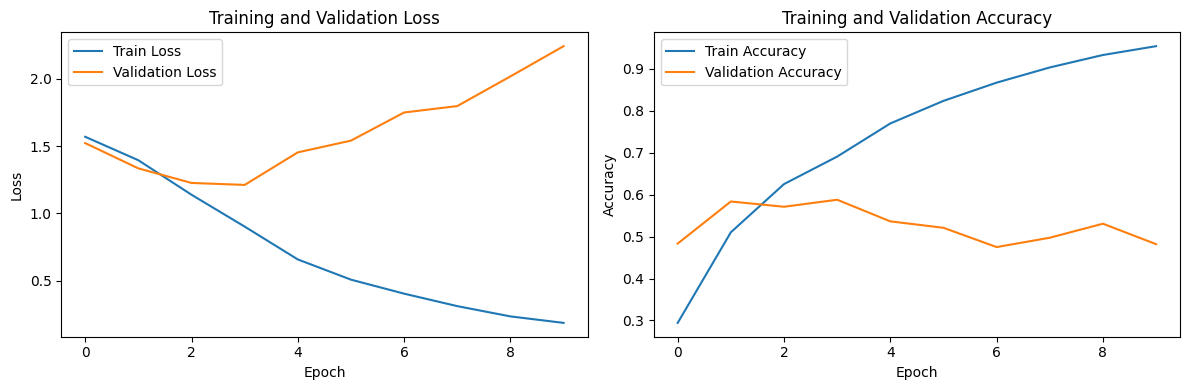

In [16]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(Config.RESULTS_DIR, 'training_curves.png'))
plt.show()

### 10. Final Evaluation

Finally, we load the best saved model and evaluate its performance on the unseen test set. We print a classification report and display a confusion matrix to analyze its performance on a per-class basis.

Evaluating on test set...
Loaded best model from epoch 4 with validation accuracy: 0.5877


Validating:   0%|          | 0/29 [00:00<?, ?it/s]

/tmp/ipython-input-2300142235.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Test Loss: 1.2094
Test Accuracy: 0.5400

Classification Report:
              precision    recall  f1-score   support

           w       0.75      0.68      0.71       290
           d       0.24      0.29      0.27       188
           a       0.46      0.53      0.49        98
           s       0.65      0.57      0.61       315
       space       0.11      0.22      0.14         9

    accuracy                           0.54       900
   macro avg       0.44      0.46      0.44       900
weighted avg       0.57      0.54      0.55       900



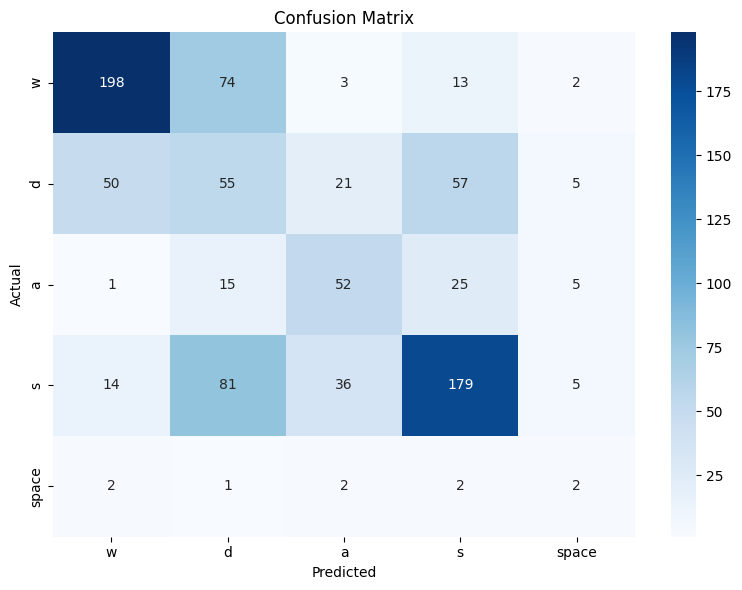

In [17]:
# Test evaluation
print("Evaluating on test set...")
best_model_path = os.path.join(Config.MODEL_SAVE_DIR, 'best_model.pth')
if os.path.exists(best_model_path):
    # Load the best model's state dict
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']+1} with validation accuracy: {checkpoint['val_acc']:.4f}")

    # The validation function is used here for evaluation on the test set
    test_loss, test_acc, test_predictions, test_labels = validate_epoch(
        model, test_loader, criterion, device)

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')

    # Classification report
    print("\nClassification Report:")
    print(classification_report(test_labels, test_predictions,
                                target_names=list(Config.LABEL_MAPPING.keys())))

    # Confusion matrix
    cm = confusion_matrix(test_labels, test_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(Config.LABEL_MAPPING.keys()),
                yticklabels=list(Config.LABEL_MAPPING.keys()))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(os.path.join(Config.RESULTS_DIR, 'confusion_matrix.png'))
    plt.show()
else:
    print(f"No model found at {best_model_path}. Skipping evaluation.")

### 11. Save Final Results

We save the final metrics and configuration to a JSON file for easy access and reproducibility.

In [18]:
results = {
    'test_accuracy': test_acc if 'test_acc' in locals() else 'N/A',
    'test_loss': test_loss if 'test_loss' in locals() else 'N/A',
    'best_val_accuracy': best_val_acc,
    'config': Config.__dict__(),
    'label_mapping': Config.LABEL_MAPPING
}

results_path = os.path.join(Config.RESULTS_DIR, 'results.json')
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nTraining completed! Results saved in {Config.RESULTS_DIR}")
print(f"Best model saved in {Config.MODEL_SAVE_DIR}")

TypeError: 'mappingproxy' object is not callable